In [253]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
#import gridsearchcv and lasso and kfold
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
# Use GBC to predict the outcome
from sklearn.ensemble import GradientBoostingClassifier


In [440]:
training = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")

In [441]:
all_data = training.append(test, ignore_index=True)

all_data['outcome'] = (all_data['metric_locked_percent_first_114_lockable_days_v1']>0.7).astype(int)
all_data = all_data.drop(columns=['finance_order_id','metric_locked_percent_first_114_lockable_days_v1'])
all_data['weekend'] = all_data['time_day_of_week_v1'].apply(lambda x: x in [5,6,7]).astype(int)
all_data.head(10)

,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,clerk_fpd_15_last_28_mature_days_v1,...,credit_account_count_payment_frequency_biweekly_mx_v1,credit_account_count_payment_frequency_bimonthly_mx_v1,credit_account_count_payment_frequency_annually_mx_v1,credit_account_count_distinct_account_type_mx_v1,credit_account_count_distinct_credit_type_mx_v1,credit_account_count_distinct_creditor_mx_v1,credit_account_count_distinct_warning_mx_v1,credit_account_count_creditor_motorcyle_finance_company_mx_v1,outcome,weekend
0,1639665815,93.0,2.0,15.0,435.0,281.0,0.166667,0.000000,0.000000,0.000000,...,0,0,0,1,1,1,0,0,0,0
1,1639666973,636.0,45.0,176.0,492.0,279.0,0.023256,0.000000,0.021277,0.000000,...,0,0,0,1,1,1,0,0,0,0
2,1639667578,386.0,19.0,54.0,568.0,279.0,0.083333,0.000000,0.000000,0.022222,...,0,0,0,2,2,2,1,0,0,0
3,1639671052,15.0,4.0,15.0,295.0,280.0,0.000000,0.000000,0.000000,NaN,...,0,0,0,2,3,2,1,0,1,0
4,1639671273,1263.0,30.0,104.0,964.0,279.0,0.151515,0.090909,0.000000,0.000000,...,0,0,0,3,3,3,2,0,0,0
5,1639671698,924.0,56.0,143.0,792.0,279.0,0.000000,0.000000,0.019231,0.010870,...,0,0,0,1,1,1,0,0,0,0
6,1639671710,579.0,15.0,65.0,801.0,280.0,0.100000,0.050000,0.000000,0.000000,...,0,0,0,1,2,2,1,0,0,0
7,1639672338,123.0,5.0,13.0,557.0,279.0,0.000000,0.000000,0.000000,0.125000,...,18,0,0,2,3,4,1,0,0,0
8,1639673380,453.0,11.0,51.0,908.0,279.0,0.250000,0.133333,0.076923,0.016949,...,0,0,0,1,1,2,0,0,1,0
9,1639673841,63.0,9.0,42.0,340.0,279.0,0.071429,0.000000,0.000000,0.045455,...,0,0,0,4,4,5,1,0,0,0


In [442]:
features=all_data.columns
#Remove 'outcome from features
features = features.drop('outcome')
print(features)

Index(['application_time', 'clerk_loan_count_total_v1',
       'clerk_loan_count_last_7_days_v1', 'clerk_loan_count_last_28_days_v1',
       'clerk_loan_days_since_first_v1', 'clerk_loan_days_since_last_v1',
       'clerk_fpd_1_last_7_mature_days_v1',
       'clerk_fpd_3_last_7_mature_days_v1',
       'clerk_fpd_7_last_14_mature_days_v1',
       'clerk_fpd_15_last_28_mature_days_v1',
       ...
       'credit_account_count_payment_frequency_monthly_mx_v1',
       'credit_account_count_payment_frequency_biweekly_mx_v1',
       'credit_account_count_payment_frequency_bimonthly_mx_v1',
       'credit_account_count_payment_frequency_annually_mx_v1',
       'credit_account_count_distinct_account_type_mx_v1',
       'credit_account_count_distinct_credit_type_mx_v1',
       'credit_account_count_distinct_creditor_mx_v1',
       'credit_account_count_distinct_warning_mx_v1',
       'credit_account_count_creditor_motorcyle_finance_company_mx_v1',
       'weekend'],
      dtype='object', length=

In [443]:
#split features into categorical and numerical
cat_features = all_data[features].select_dtypes(include=['object']).columns
num_features = all_data[features].select_dtypes(exclude=['object']).columns

print(cat_features)
print(num_features)

Index(['merchant_state_v1', 'merchant_region_mx_v1', 'user_state_v1',
       'user_region_mx_v1',
       'user_photo_similarity_score_max_is_over_99_point_993_mx_v1',
       'credit_inquiry_days_since_last_at_most_1_mx_v1'],
      dtype='object')
Index(['application_time', 'clerk_loan_count_total_v1',
       'clerk_loan_count_last_7_days_v1', 'clerk_loan_count_last_28_days_v1',
       'clerk_loan_days_since_first_v1', 'clerk_loan_days_since_last_v1',
       'clerk_fpd_1_last_7_mature_days_v1',
       'clerk_fpd_3_last_7_mature_days_v1',
       'clerk_fpd_7_last_14_mature_days_v1',
       'clerk_fpd_15_last_28_mature_days_v1',
       ...
       'credit_account_count_payment_frequency_monthly_mx_v1',
       'credit_account_count_payment_frequency_biweekly_mx_v1',
       'credit_account_count_payment_frequency_bimonthly_mx_v1',
       'credit_account_count_payment_frequency_annually_mx_v1',
       'credit_account_count_distinct_account_type_mx_v1',
       'credit_account_count_distinct_cr

In [444]:
all_data_cat = pd.get_dummies(all_data[cat_features], drop_first = True)

#drop the categorical features from the original dataset
all_data = all_data.drop(cat_features, axis = 1)

#concatenate the dummy variables with the original dataset
all_data_binned = pd.concat([all_data, all_data_cat], axis = 1)

#store only the categorical features in a list
all_data_cat.rename(columns={'merchant_state_v1_nuevo león':'merchant_state_v1_nuevoLeon'},inplace=True)
all_data_cat['merchant_state_v1_nuevoLeon'] = all_data_cat['merchant_state_v1_nuevoLeon'] + all_data_cat['merchant_state_v1_nuevo leon']
all_data_cat = all_data_cat.drop(columns=['merchant_state_v1_nuevo leon'])
cat_features = all_data_cat.columns

all_data_binned.rename(columns={'merchant_state_v1_nuevo león':'merchant_state_v1_nuevoLeon'},inplace=True)

#merge colums 'merchant_state_v1_nuevo leon' and 'merchant_state_v1_nuevoLeon'
all_data_binned['merchant_state_v1_nuevoLeon'] = all_data_binned['merchant_state_v1_nuevoLeon'] + all_data_binned['merchant_state_v1_nuevo leon']
all_data_binned = all_data_binned.drop(columns=['merchant_state_v1_nuevo leon'])

all_data_binned.head(10)

,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,clerk_fpd_15_last_28_mature_days_v1,...,user_region_mx_v1_region_2,user_region_mx_v1_region_3,user_region_mx_v1_region_4,user_region_mx_v1_region_5,user_region_mx_v1_region_6,user_region_mx_v1_region_7,user_region_mx_v1_region_8,user_region_mx_v1_region_9,user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True,credit_inquiry_days_since_last_at_most_1_mx_v1_True
0,1639665815,93.0,2.0,15.0,435.0,281.0,0.166667,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,1639666973,636.0,45.0,176.0,492.0,279.0,0.023256,0.000000,0.021277,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,1639667578,386.0,19.0,54.0,568.0,279.0,0.083333,0.000000,0.000000,0.022222,...,0,0,0,0,0,0,1,0,0,0
3,1639671052,15.0,4.0,15.0,295.0,280.0,0.000000,0.000000,0.000000,NaN,...,0,0,0,1,0,0,0,0,1,0
4,1639671273,1263.0,30.0,104.0,964.0,279.0,0.151515,0.090909,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
5,1639671698,924.0,56.0,143.0,792.0,279.0,0.000000,0.000000,0.019231,0.010870,...,0,1,0,0,0,0,0,0,0,0
6,1639671710,579.0,15.0,65.0,801.0,280.0,0.100000,0.050000,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
7,1639672338,123.0,5.0,13.0,557.0,279.0,0.000000,0.000000,0.000000,0.125000,...,0,0,1,0,0,0,0,0,0,0
8,1639673380,453.0,11.0,51.0,908.0,279.0,0.250000,0.133333,0.076923,0.016949,...,0,0,0,1,0,0,0,0,0,0
9,1639673841,63.0,9.0,42.0,340.0,279.0,0.071429,0.000000,0.000000,0.045455,...,0,0,1,0,0,0,0,0,0,0


In [296]:
currentFeatBest=['device_model_first_sale_time_months_since_v1',
       'weekend',
       'device_model_first_sale_time_months_since_v1',
       'device_model_first_sale_time_months_since_v1',
       'credit_inquiry_count_type_unsecured_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1',
       'credit_score_circulo_fico_mx_v1',
       'clerk_loan_count_total_v1',
       'merchant_loan_count_total_v1',
       'credit_utilization_max_updated_last_6_months_mx_v1',
       'credit_payment_days_since_last_mx_v1',
       'credit_limit_total_type_bank_card_updated_last_6_months_mx_v1',
       'credit_limit_max_type_bank_card_mx_v1',
       'credit_limit_max_mx_v1',
       'credit_limit_min_mx_v1',
       'credit_inquiry_days_since_last_type_unknown_mx_v1',
       'credit_inquiry_days_since_last_type_personal_loan_mx_v1',
       'credit_inquiry_days_since_last_type_installment_mx_v1',
       'credit_inquiry_days_since_last_creditor_sic_mx_v1',
       'credit_inquiry_days_since_last_creditor_bank_mx_v1',
       'credit_delinquent_periods_total_mx_v1'
       ]

In [297]:
#fill nans from current features columns
all_data_binned[currentFeatBest].fillna(0, inplace=True)
all_data_binned.head(10)

,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,clerk_fpd_15_last_28_mature_days_v1,...,user_region_mx_v1_region_2,user_region_mx_v1_region_3,user_region_mx_v1_region_4,user_region_mx_v1_region_5,user_region_mx_v1_region_6,user_region_mx_v1_region_7,user_region_mx_v1_region_8,user_region_mx_v1_region_9,user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True,credit_inquiry_days_since_last_at_most_1_mx_v1_True
0,1639665815,93.0,2.0,15.0,435.0,281.0,0.166667,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,1639666973,636.0,45.0,176.0,492.0,279.0,0.023256,0.000000,0.021277,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,1639667578,386.0,19.0,54.0,568.0,279.0,0.083333,0.000000,0.000000,0.022222,...,0,0,0,0,0,0,1,0,0,0
3,1639671052,15.0,4.0,15.0,295.0,280.0,0.000000,0.000000,0.000000,NaN,...,0,0,0,1,0,0,0,0,1,0
4,1639671273,1263.0,30.0,104.0,964.0,279.0,0.151515,0.090909,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
5,1639671698,924.0,56.0,143.0,792.0,279.0,0.000000,0.000000,0.019231,0.010870,...,0,1,0,0,0,0,0,0,0,0
6,1639671710,579.0,15.0,65.0,801.0,280.0,0.100000,0.050000,0.000000,0.000000,...,0,1,0,0,0,0,0,0,0,0
7,1639672338,123.0,5.0,13.0,557.0,279.0,0.000000,0.000000,0.000000,0.125000,...,0,0,1,0,0,0,0,0,0,0
8,1639673380,453.0,11.0,51.0,908.0,279.0,0.250000,0.133333,0.076923,0.016949,...,0,0,0,1,0,0,0,0,0,0
9,1639673841,63.0,9.0,42.0,340.0,279.0,0.071429,0.000000,0.000000,0.045455,...,0,0,1,0,0,0,0,0,0,0


In [404]:
training_processed = all_data_binned.iloc[0:len(training),:]
test_processed = all_data_binned.iloc[len(training):len(all_data_binned),:]

In [405]:
training_processed['outcome'].describe()

count    25000.000000
mean         0.181240
std          0.385225
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: outcome, dtype: float64

In [445]:
n_mock_training = int(len(training_processed)*0.7)

mock_training = training_processed.iloc[0:n_mock_training,:]
mock_test = training_processed.iloc[n_mock_training:len(training_processed),:]

**Logit reg to test cat variables**

In [300]:
#add cat features to the formula
formula='outcome ~ '+ cat_features[0]
for i in range(len(cat_features)-1):
    formula += ' + '+cat_features[i]

model_logit = smf.glm(formula=formula, data = all_data_binned, family=sm.families.Binomial()).fit()
validationProbs_logit  = model_logit.predict(mock_test)
print(model_logit.summary())

#Calculate AUC for model_Q8
fpr, tpr, threshold = roc_curve(mock_test['outcome'],validationProbs_logit)
roc_auc = auc(fpr, tpr)
print('AUC for model is: '+str(roc_auc))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                50000
Model:                            GLM   Df Residuals:                    49933
Model Family:                Binomial   Df Model:                           66
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 19 Feb 2023   Deviance:                       31331.
Time:                        23:25:22   Pearson chi2:                 5.08e+04
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

In [304]:
trainingPredictorsAsMatrix = np.asarray(training_processed.loc[:,cat_features])
validationPredictorsAsMatrix = np.asarray(training_processed.loc[:,cat_features])

In [305]:
def plot_cv_results(clf, lambdas, print_best = True):
    cv_Results = pd.DataFrame(columns=['Lambda','AUC','SE_AUC'])
    cv_Results['Lambda'] = lambdas
    cv_Results['AUC'] = clf.cv_results_['mean_test_score']
    cv_Results['SE_AUC'] = clf.cv_results_['std_test_score']
    
    if print_best:
        auc_max = np.round(np.max(clf.cv_results_['mean_test_score']),3)
        lambda_max = np.round(lambdas[np.argmax(clf.cv_results_['mean_test_score'])],2)
        print('Best AUC=',auc_max,'achieved at lambda=',lambda_max)

    plt.errorbar(data = cv_Results, x='Lambda', y='AUC', yerr='SE_AUC',
                 color='black',ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('AUC')
    plt.show()

Log reg + lasso at best lambda achieves validation set of AUC= 0.5880885283793994


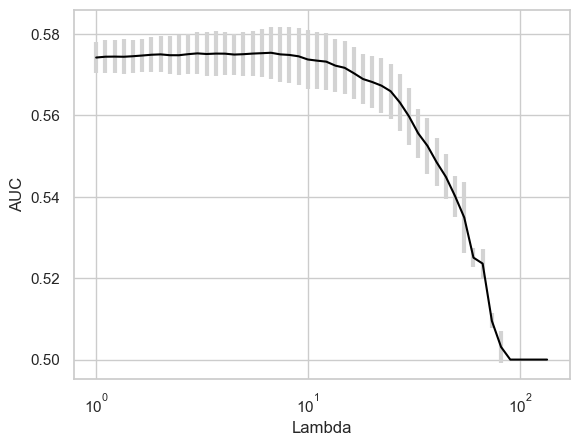

In [310]:
lambdas = np.exp(np.arange(0,5,0.1))
tuned_parameters = [{'C':1/lambdas,
                     'penalty':['l1'], 
                     'solver':['liblinear'],
                     'warm_start':[True]}]

model_lasso_cv = GridSearchCV(LogisticRegression(), tuned_parameters, scoring= 'roc_auc', 
                              cv = KFold(n_splits=5, random_state=None, shuffle=True))

model_lasso_cv.fit(trainingPredictorsAsMatrix, training_processed['outcome'])

valid_pred_lasso = model_lasso_cv.predict_proba(validationPredictorsAsMatrix)[:,1]

print('Log reg + lasso at best lambda achieves validation set of AUC=',roc_auc_score(training_processed['outcome'],valid_pred_lasso))

plot_cv_results(model_lasso_cv, lambdas, print_best= False)

In [311]:
features_names = list(cat_features)
features_names.append('intercept')
all_coeff = np.append(model_lasso_cv.best_estimator_.coef_,model_lasso_cv.best_estimator_.intercept_)

coefficients_matrix = pd.DataFrame(data = {'Features': features_names, 'Coefficient':all_coeff})

nnz = np.sum(np.abs(all_coeff)>0)
print('Out of',len(cat_features),'features,',nnz,'are selected by the Lasso.\n\n', coefficients_matrix.loc[np.abs(all_coeff)>0,:])

#get features selected by lasso without intercept
selected_features = list(coefficients_matrix.loc[np.abs(all_coeff)>0,'Features'])[:-1]
CatLasso=selected_features

Out of 82 features, 41 are selected by the Lasso.

                                              Features  Coefficient
1                               merchant_state_v1_bcs    -0.215527
2                              merchant_state_v1_camp    -0.046775
4                              merchant_state_v1_chih    -0.189697
5                              merchant_state_v1_chis     0.087758
9                               merchant_state_v1_gro    -0.579744
10                              merchant_state_v1_gto    -0.265127
13                              merchant_state_v1_mex     0.043694
16                              merchant_state_v1_nay    -0.245891
17                               merchant_state_v1_nl     0.142531
20                              merchant_state_v1_pue     0.193033
23                              merchant_state_v1_sin     0.043875
25                              merchant_state_v1_son    -0.201165
27                             merchant_state_v1_tamp    -0.035779
29        

In [312]:
#add cat features to the formula
formula='outcome ~ '+ CatLasso[0]
for i in range(len(CatLasso)-1):
    formula += ' + '+CatLasso[i+1]
  

model_logit = smf.glm(formula=formula, data = mock_training, family=sm.families.Binomial()).fit()
validationProbs_logit  = model_logit.predict(mock_test)
print(model_logit.summary())

#Calculate AUC for model_Q8
fpr, tpr, threshold = roc_curve(mock_test['outcome'],validationProbs_logit)
roc_auc = auc(fpr, tpr)
print('AUC for model is: '+str(roc_auc))

probsLogit=model_logit.predict(test_processed)

print(probsLogit)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                17500
Model:                            GLM   Df Residuals:                    17459
Model Family:                Binomial   Df Model:                           40
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8052.5
Date:                Sun, 19 Feb 2023   Deviance:                       16105.
Time:                        23:30:46   Pearson chi2:                 1.75e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01369
Covariance Type:            nonrobust                                         
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

**Forward Selection**

In [326]:
mock_training.fillna(0,inplace=True);
mock_test.fillna(0, inplace=True);

In [328]:
# Initialization

current_formula = 'outcome ~' # This keeps track of the best formula (on features tried)
currValidationAUC = 0 # Calculates the current profit, we initialize it by 0
currentFeat=[] ## This keeps track of featueres that are selected throughout the process
remainingFeat = list(currentFeatBest) # This keeps track of remaining features throughout the process

# Filter numpy warnings
import warnings
warnings.filterwarnings('ignore')

for i in range(len(currentFeatBest)): 
    
    ## First loop represents each step (adding a i^th variable).
    ## This loop tries to add the best feature among the ones that have not been selected yet.
    
    newValidationAUC = np.zeros(len(remainingFeat))
    
    for j in range(len(remainingFeat)):
        
        ## Second loop iterates over all existing features that have not been selected yet.
        ## It calculates validation profit by adding them one by one and picking the best one.
        
        #join current feats with the new feature
        newFeat=currentFeat+[remainingFeat[j]]


        modelGBM = GradientBoostingClassifier(n_estimators=100) #n_estimators denotes the number of trees that are constructed
        X=mock_training.loc[:,newFeat]
        y=mock_training['outcome']
        modelGBM.fit(X,y)
        validationProbsGBM  = modelGBM.predict_proba(mock_test.loc[:,newFeat])[:,1]
        # Calculate AUC for model
        newValidationAUC[j] = roc_auc_score(mock_test['outcome'],validationProbsGBM)
        
    ## Here we select the best feature (largest validation AUC)

    ind = np.argmax(newValidationAUC)
    
    ## We add this best feature only if new profit is larger than the previous one.
    ## Otherwise we stop the process.

    if newValidationAUC[ind] > currValidationAUC:
        
        ## Here we update the list containing current features and remaining features.
        ## We also update the current formula.
        
        currValidationAUC = newValidationAUC[ind]
        currentFeat.append(remainingFeat[ind])
        current_formula = current_formula + ' + ' + remainingFeat[ind]
        remainingFeat =  list(set(currentFeatBest) - set(currentFeat))
        print('AUC using variable(s) ', currentFeat, 'is :', np.round(currValidationAUC,3))

print('----------------')   
print('Best AUC using forward selection: ', np.round(currValidationAUC,3))
print('This AUC is achieved using features: ', currentFeat)
print('Variables not used in the final model:',remainingFeat)

Profit using variable(s)  ['clerk_loan_count_total_v1'] is : 0.576
Profit using variable(s)  ['clerk_loan_count_total_v1', 'device_model_first_sale_time_months_since_v1'] is : 0.601
Profit using variable(s)  ['clerk_loan_count_total_v1', 'device_model_first_sale_time_months_since_v1', 'credit_inquiry_days_since_last_type_installment_mx_v1'] is : 0.612
Profit using variable(s)  ['clerk_loan_count_total_v1', 'device_model_first_sale_time_months_since_v1', 'credit_inquiry_days_since_last_type_installment_mx_v1', 'credit_utilization_max_updated_last_6_months_mx_v1'] is : 0.613
Profit using variable(s)  ['clerk_loan_count_total_v1', 'device_model_first_sale_time_months_since_v1', 'credit_inquiry_days_since_last_type_installment_mx_v1', 'credit_utilization_max_updated_last_6_months_mx_v1', 'weekend'] is : 0.614
Profit using variable(s)  ['clerk_loan_count_total_v1', 'device_model_first_sale_time_months_since_v1', 'credit_inquiry_days_since_last_type_installment_mx_v1', 'credit_utilization_ma

In [329]:
forwardSelectionNum = ['clerk_loan_count_total_v1', 'device_model_first_sale_time_months_since_v1', 'credit_inquiry_days_since_last_type_installment_mx_v1', 'credit_utilization_max_updated_last_6_months_mx_v1', 'weekend', 'credit_score_circulo_fico_mx_v1', 'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1', 'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1', 'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1']

In [331]:
# Initialization

current_formula = 'outcome ~' # This keeps track of the best formula (on features tried)
currValidationAUC = 0 # Calculates the current profit, we initialize it by 0
currentFeat=[] ## This keeps track of featueres that are selected throughout the process
remainingFeat = list(CatLasso) # This keeps track of remaining features throughout the process

# Filter numpy warnings
import warnings
warnings.filterwarnings('ignore')

for i in range(len(CatLasso)): 
    
    ## First loop represents each step (adding a i^th variable).
    ## This loop tries to add the best feature among the ones that have not been selected yet.
    
    newValidationAUC = np.zeros(len(remainingFeat))
    
    for j in range(len(remainingFeat)):
        
        ## Second loop iterates over all existing features that have not been selected yet.
        ## It calculates validation profit by adding them one by one and picking the best one.
        
        #join current feats with the new feature
        newFeat=currentFeat+[remainingFeat[j]]


        modelGBM = GradientBoostingClassifier(n_estimators=100) #n_estimators denotes the number of trees that are constructed
        X=mock_training.loc[:,newFeat]
        y=mock_training['outcome']
        modelGBM.fit(X,y)
        validationProbsGBM  = modelGBM.predict_proba(mock_test.loc[:,newFeat])[:,1]
        # Calculate AUC for model
        newValidationAUC[j] = roc_auc_score(mock_test['outcome'],validationProbsGBM)
        
    ## Here we select the best feature (largest validation AUC)

    ind = np.argmax(newValidationAUC)
    
    ## We add this best feature only if new profit is larger than the previous one.
    ## Otherwise we stop the process.

    if newValidationAUC[ind] > currValidationAUC:
        
        ## Here we update the list containing current features and remaining features.
        ## We also update the current formula.
        
        currValidationAUC = newValidationAUC[ind]
        currentFeat.append(remainingFeat[ind])
        current_formula = current_formula + ' + ' + remainingFeat[ind]
        remainingFeat =  list(set(CatLasso) - set(currentFeat))
        print('Profit using variable(s) ', currentFeat, 'is :', np.round(currValidationAUC,3))

print('----------------')   
print('Best AUC using forward selection: ', np.round(currValidationAUC,3))
print('This AUC is achieved using features: ', currentFeat)
print('Variables not used in the final model:',remainingFeat)

Profit using variable(s)  ['merchant_region_mx_v1_region_8'] is : 0.522
Profit using variable(s)  ['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl'] is : 0.538
Profit using variable(s)  ['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl', 'user_state_v1_ver'] is : 0.55
Profit using variable(s)  ['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl', 'user_state_v1_ver', 'user_state_v1_bc'] is : 0.556
Profit using variable(s)  ['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl', 'user_state_v1_ver', 'user_state_v1_bc', 'user_state_v1_sin'] is : 0.562
Profit using variable(s)  ['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl', 'user_state_v1_ver', 'user_state_v1_bc', 'user_state_v1_sin', 'user_state_v1_chis'] is : 0.567
Profit using variable(s)  ['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl', 'user_state_v1_ver', 'user_state_v1_bc', 'user_state_v1_sin', 'user_state_v1_chis', 'user_state_v1_mich'] is : 0.572
Profit using variable(s)  ['merchant_re

In [356]:
currentFeat=['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl', 'user_state_v1_ver', 'user_state_v1_bc', 'user_state_v1_sin', 'user_state_v1_chis', 'user_state_v1_mich', 'user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True', 'merchant_state_v1_zac', 'merchant_state_v1_gto', 'user_state_v1_bcs', 'merchant_state_v1_gro', 'user_state_v1_tamp', 'merchant_state_v1_son', 'user_state_v1_jal', 'merchant_region_mx_v1_region_3', 'merchant_state_v1_nay', 'merchant_state_v1_sin', 'user_state_v1_nl', 'user_state_v1_camp']

#print size of currentFeat
print(len(currentFeat))

20


In [357]:
#make currentfeat joining forwardSelectionNum and CatLasso

currentFeatFinal = currentFeat + forwardSelectionNum

print(currentFeatFinal)

['merchant_region_mx_v1_region_8', 'merchant_state_v1_nl', 'user_state_v1_ver', 'user_state_v1_bc', 'user_state_v1_sin', 'user_state_v1_chis', 'user_state_v1_mich', 'user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True', 'merchant_state_v1_zac', 'merchant_state_v1_gto', 'user_state_v1_bcs', 'merchant_state_v1_gro', 'user_state_v1_tamp', 'merchant_state_v1_son', 'user_state_v1_jal', 'merchant_region_mx_v1_region_3', 'merchant_state_v1_nay', 'merchant_state_v1_sin', 'user_state_v1_nl', 'user_state_v1_camp', 'clerk_loan_count_total_v1', 'device_model_first_sale_time_months_since_v1', 'credit_inquiry_days_since_last_type_installment_mx_v1', 'credit_utilization_max_updated_last_6_months_mx_v1', 'weekend', 'credit_score_circulo_fico_mx_v1', 'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1', 'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1', 'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1']


In [344]:
# Initialization

current_formula = 'outcome ~' # This keeps track of the best formula (on features tried)
currValidationAUC = 0 # Calculates the current profit, we initialize it by 0
currentFeat=[] ## This keeps track of featueres that are selected throughout the process
remainingFeat = list(currentFeatFinal) # This keeps track of remaining features throughout the process

# Filter numpy warnings
import warnings
warnings.filterwarnings('ignore')

for i in range(len(currentFeatFinal)): 
    
    ## First loop represents each step (adding a i^th variable).
    ## This loop tries to add the best feature among the ones that have not been selected yet.
    
    newValidationAUC = np.zeros(len(remainingFeat))
    
    for j in range(len(remainingFeat)):
        
        ## Second loop iterates over all existing features that have not been selected yet.
        ## It calculates validation profit by adding them one by one and picking the best one.
        
        #join current feats with the new feature
        newFeat=currentFeat+[remainingFeat[j]]


        modelGBM = GradientBoostingClassifier(n_estimators=100) #n_estimators denotes the number of trees that are constructed
        X=mock_training.loc[:,newFeat]
        y=mock_training['outcome']
        modelGBM.fit(X,y)
        validationProbsGBM  = modelGBM.predict_proba(mock_test.loc[:,newFeat])[:,1]
        # Calculate AUC for model
        newValidationAUC[j] = roc_auc_score(mock_test['outcome'],validationProbsGBM)
        
    ## Here we select the best feature (largest validation AUC)

    ind = np.argmax(newValidationAUC)
    
    ## We add this best feature only if new profit is larger than the previous one.
    ## Otherwise we stop the process.

    if newValidationAUC[ind] > currValidationAUC:
        
        ## Here we update the list containing current features and remaining features.
        ## We also update the current formula.
        
        currValidationAUC = newValidationAUC[ind]
        currentFeat.append(remainingFeat[ind])
        current_formula = current_formula + ' + ' + remainingFeat[ind]
        remainingFeat =  list(set(CatLasso) - set(currentFeat))
        print('Profit using variable(s) ', currentFeat, 'is :', np.round(currValidationAUC,3))

print('----------------')   
print('Best AUC using forward selection: ', np.round(currValidationAUC,3))
print('This AUC is achieved using features: ', currentFeat)
print('Variables not used in the final model:',remainingFeat)

Profit using variable(s)  ['clerk_loan_count_total_v1'] is : 0.576
Profit using variable(s)  ['clerk_loan_count_total_v1', 'merchant_state_v1_gro'] is : 0.581
Profit using variable(s)  ['clerk_loan_count_total_v1', 'merchant_state_v1_gro', 'user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True'] is : 0.586
Profit using variable(s)  ['clerk_loan_count_total_v1', 'merchant_state_v1_gro', 'user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True', 'merchant_state_v1_bcs'] is : 0.593
Profit using variable(s)  ['clerk_loan_count_total_v1', 'merchant_state_v1_gro', 'user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True', 'merchant_state_v1_bcs', 'user_state_v1_ver'] is : 0.596
Profit using variable(s)  ['clerk_loan_count_total_v1', 'merchant_state_v1_gro', 'user_photo_similarity_score_max_is_over_99_point_993_mx_v1_True', 'merchant_state_v1_bcs', 'user_state_v1_ver', 'merchant_state_v1_gto'] is : 0.6
Profit using variable(s)  ['clerk_loan_count_total_v1', 'merchant

**Lasso**

In [358]:
trainingPredictorsAsMatrix = np.asarray(mock_training.loc[:,currentFeatFinal])
validationPredictorsAsMatrix = np.asarray(mock_test.loc[:,currentFeatFinal])

Log reg + lasso at best lambda achieves validation set of AUC= 0.609267359675403


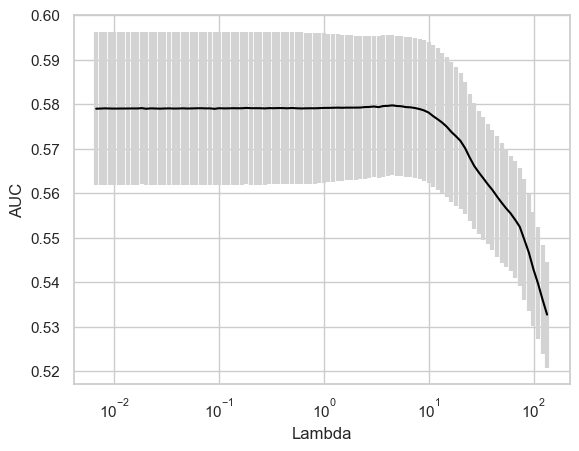

In [359]:
lambdas = np.exp(np.arange(-5,5,0.1))
tuned_parameters = [{'C':1/lambdas,
                     'penalty':['l1'], 
                     'solver':['liblinear'],
                     'warm_start':[True]}]

model_lasso_cv = GridSearchCV(LogisticRegression(), tuned_parameters, scoring= 'roc_auc', 
                              cv = KFold(n_splits=5, random_state=None, shuffle=True))

model_lasso_cv.fit(trainingPredictorsAsMatrix, mock_training['outcome'])

valid_pred_lasso = model_lasso_cv.predict_proba(validationPredictorsAsMatrix)[:,1]

print('Log reg + lasso at best lambda achieves validation set of AUC=',roc_auc_score(mock_test['outcome'],valid_pred_lasso))

plot_cv_results(model_lasso_cv, lambdas, print_best= False)

In [360]:
features_names = list(currentFeatFinal)
features_names.append('intercept')
all_coeff = np.append(model_lasso_cv.best_estimator_.coef_,model_lasso_cv.best_estimator_.intercept_)

coefficients_matrix = pd.DataFrame(data = {'Features': features_names, 'Coefficient':all_coeff})

nnz = np.sum(np.abs(all_coeff)>0)
print('Out of',len(currentFeatFinal),'features,',nnz,'are selected by the Lasso.\n\n', coefficients_matrix.loc[np.abs(all_coeff)>0,:])

#get features selected by lasso without intercept
selected_features = list(coefficients_matrix.loc[np.abs(all_coeff)>0,'Features'])[:-1]
currentFeat=selected_features

Out of 29 features, 25 are selected by the Lasso.

                                              Features  Coefficient
1                                merchant_state_v1_nl     0.015816
2                                   user_state_v1_ver     0.273114
3                                    user_state_v1_bc    -0.121372
4                                   user_state_v1_sin     0.293148
5                                  user_state_v1_chis     0.067805
6                                  user_state_v1_mich     0.021050
7   user_photo_similarity_score_max_is_over_99_poi...     0.313883
8                               merchant_state_v1_zac     0.157968
9                               merchant_state_v1_gto    -0.196553
10                                  user_state_v1_bcs    -0.881679
11                              merchant_state_v1_gro    -0.500698
12                                 user_state_v1_tamp    -0.095817
13                              merchant_state_v1_son    -0.206600
14        

In [417]:
#fill missing values from currentFeat columns with 0 in the test set
test_processed.fillna(0, inplace=True)
mock_training.fillna(0,inplace=True)
mock_test.fillna(0,inplace=True)

**GBM**

In [446]:
modelGBM = GradientBoostingClassifier(n_estimators=800) #n_estimators denotes the number of trees that are constructed
X=mock_training.loc[:,currentFeat]
y=mock_training['outcome']
modelGBM.fit(X,y)
validationProbsGBM  = modelGBM.predict_proba(mock_test.loc[:,currentFeat])[:,1]

print('AUC of GBM model is',roc_auc_score(mock_test['outcome'], validationProbsGBM),'\n')

probsGBM=modelGBM.predict_proba(test_processed.loc[:,currentFeat])[:,1]

print(probsGBM)

#confusion matrix cutoff 0.7
confusion_matrix(mock_test['outcome'], validationProbsGBM>0.7)


AUC of GBM model is 0.617752416048427 

[0.16145108 0.12142862 0.05634015 ... 0.12757826 0.04858773 0.11316344]


array([[6058,   11],
       [1417,   14]])

In [447]:
submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsGBM
submission.to_csv("benchmarkGBM.csv",index = False)
submission.head()

,Id,Predicted
0,2025000,0.161451
1,2025001,0.121429
2,2025002,0.056340
3,2025003,0.162244
4,2025004,0.285719


**Logit**

In [411]:
#add cat features to the formula
formula='outcome ~ '+ currentFeatFinal[0]
for i in range(len(currentFeatFinal)-1):
    formula += ' + '+currentFeatFinal[i]

#add interactions to the formula
for i in range(len(currentFeatFinal)):
    for j in range(i+1,len(currentFeatFinal)):
        formula += ' + '+currentFeatFinal[i]+'*'+currentFeatFinal[j]


model_logit = smf.glm(formula=formula, data = mock_training, family=sm.families.Binomial()).fit()
validationProbs_logit  = model_logit.predict(mock_test)
print(model_logit.summary())

#Calculate AUC 
fpr, tpr, threshold = roc_curve(mock_test['outcome'],validationProbs_logit)
roc_auc = auc(fpr, tpr)
print('AUC for model is: '+str(roc_auc))

testProbsLogit=model_logit.predict(test_processed)
print(testProbsLogit)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                17500
Model:                            GLM   Df Residuals:                    17255
Model Family:                Binomial   Df Model:                          244
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 20 Feb 2023   Deviance:                       15773.
Time:                        01:38:21   Pearson chi2:                 1.74e+04
No. Iterations:                    23   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                                                                                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------

In [415]:
submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = testProbsLogit.values
submission.to_csv("benchmarkLogit.csv",index = False)
submission.head()

,Id,Predicted
0,2025000,0.161878
1,2025001,0.182472
2,2025002,0.167401
3,2025003,0.156104
4,2025004,0.262887


**ANN**

In [376]:
# Separate Target Variable and Predictor Variables
TargetVariable=['outcome']
featuresANN=currentFeat

X=training_processed.loc[:,featuresANN]
y=training_processed[TargetVariable].values


### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
# Defining the Input layer and FIRST hidden layer,both are same!
# relu means Rectifier linear unit function
classifier.add(Dense(units=10, input_dim=len(currentFeat), kernel_initializer='uniform', activation='relu'))

#Defining the SECOND hidden layer, here we have not defined input because it is
# second layer and it will get input as the output of first hidden layer
classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu'))

# Defining the Output layer
# sigmoid means sigmoid activation function
# for Multiclass classification the activation ='softmax'
# And output_dim will be equal to the number of factor levels
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Optimizer== the algorithm of SGG to keep updating weights
# loss== the loss function to measure the accuracy
# metrics== the way we will compare the accuracy after each step of SGD
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fitting the Neural Network on the training data
ANN_Model=classifier.fit(X_train,y_train, batch_size=10 , epochs=10, verbose=1)

validationProbsANN  = classifier.predict(X_test)

print('AUC of ANN model is',roc_auc_score(y_test, validationProbsANN),'\n')

X=test_processed.loc[:,currentFeat]

### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)

probsANN=classifier.predict(X)

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsANN
submission.to_csv("benchmarkANN.csv",index = False)
submission.head()

(17500, 24)
(17500, 1)
(7500, 24)
(7500, 1)
Epoch 1/10


2023-02-20 00:26:07.521882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1750/1750 [==============================] - 10s 5ms/step - loss: 0.4806 - accuracy: 0.8199
Epoch 2/10
1750/1750 [==============================] - 10s 6ms/step - loss: 0.4636 - accuracy: 0.8202
Epoch 3/10
1750/1750 [==============================] - 10s 6ms/step - loss: 0.4633 - accuracy: 0.8202
Epoch 4/10
1750/1750 [==============================] - 9s 5ms/step - loss: 0.4629 - accuracy: 0.8202
Epoch 5/10
1750/1750 [==============================] - 9s 5ms/step - loss: 0.4628 - accuracy: 0.8202
Epoch 6/10
1750/1750 [==============================] - 9s 5ms/step - loss: 0.4623 - accuracy: 0.8202
Epoch 7/10
1750/1750 [==============================] - 9s 5ms/step - loss: 0.4627 - accuracy: 0.8202
Epoch 8/10
1750/1750 [==============================] - 9s 5ms/step - loss: 0.4624 - accuracy: 0.8202
Epoch 9/10
1750/1750 [==============================] - 9s 5ms/step - loss: 0.4622 - accuracy: 0.8202
Epoch 10/10
 83/235 [=========>....................] - ETA: 0s

2023-02-20 00:27:40.876518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 1s 2ms/step
AUC of ANN model is 0.5910447745324497 

782/782 [==============================] - 1s 2ms/step


,Id,Predicted
0,2025000,0.171034
1,2025001,0.256716
2,2025002,0.170113
3,2025003,0.249878
4,2025004,0.229147
